# Notebook de procesamiento de imágenes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt # plots
import matplotlib.image as mpimg # abrir imagenes
import re
import shutil
import pandas as pd
import matplotlib.patches as patches # para agregar un bounding box
import numpy as np
from PIL import Image

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Mover imagenes del formulario de respuestas a carpetas individuales
Las imagenes del formulario estan organizadas por un nombre, se deben tomar las imagenes con el mismo nombre de gato y organizar en carpetas

In [ ]:
images_path = '/content/drive/MyDrive/gatos  (File responses)/Imagen de tu gato. Sube por lo menos tres fotos. Además todas las imágenes deben ser diferentes.  Intenta que en cada imágen~. Piensa que una persona que no conoce a tu gato podría ser capaz de identificarlo visualmente con esas fotos (File responses)'
files = os.listdir(images_path)

In [ ]:
files

['23-Simba-filename_20240513_211055 - Shelsy Viviana Rios Hernandez.jpg',
 '23-Simba-filename_20240513_210839 - Shelsy Viviana Rios Hernandez.jpg',
 '23-Simba-filename_20240302_101610 - Shelsy Viviana Rios Hernandez.jpg',
 '23-Simba-filename_20230927_145941 - Shelsy Viviana Rios Hernandez.jpg',
 '23-Simba-filename_20230911_232903 - Shelsy Viviana Rios Hernandez.jpg',
 '24-Nala-filename_20240423_185848 - Shelsy Viviana Rios Hernandez.jpg',
 '24-Nala-filename_20231026_093434 - Shelsy Viviana Rios Hernandez.jpg',
 '24-Nala-filename_20230831_122801 - Shelsy Viviana Rios Hernandez.jpg',
 '24-Nala-filename_20230710_112935 - Shelsy Viviana Rios Hernandez.jpg',
 '24-Nala-filename_20230619_093517 - Shelsy Viviana Rios Hernandez.jpg',
 '25-Chinita-filename_inbound3722973625617137386 - Lareis Polo.jpg',
 '25-Chinita-filename_inbound322735783508745005 - Lareis Polo.jpg',
 '25-Chinita-filename_inbound8162044569474193244 - Lareis Polo.jpg',
 '26-Michu-filename_Screenshot_20240527_153521_Gallery - ka

In [ ]:
# voy a agrupar las imagenes por gato y guardarlo en una carpeta

# Create a dictionary to hold file groups
file_groups = {}

pattern = re.compile(r'^(.*?)-filename')
for file in files:
    match = pattern.match(file)
    if match:
      # Extract the ID (the full filename in this case)
      name = match.group(0)
      file_id = name.split('-')[0] + '-' + name.split('-')[1]
      # Add the file to the appropriate group
      if file_id not in file_groups:
        file_groups[file_id] = []
      file_groups[file_id].append(file)


In [ ]:
# Create new folders and move files
for file_id, group_files in file_groups.items():
    # Create a new folder for the group (using file_id as folder name)
    new_folder_path = os.path.join(images_path, file_id)
    os.makedirs(new_folder_path, exist_ok=True)

    # Move files to the new folder
    for file in group_files:
        src = os.path.join(images_path, file)
        dst = os.path.join(new_folder_path, file)
        shutil.move(src, dst)

# Preprocesamiento de imagenes
Aqui recorto las imagenes de los gatos en cara y cuerpo y las guardo en carpetas

### Obtener las imágenes

In [ ]:
images_path = '/content/drive/MyDrive/gatos_scrapping'
folders = os.listdir(images_path)

In [ ]:
def get_cat_path(cat):
  return '/content/drive/MyDrive/gatos_scrapping' + "/" + cat.id + "/" + cat.image

def get_cat(cat):
  return mpimg.imread(get_cat_path(cat))


def show_cat(cat):
  img = mpimg.imread(get_cat_path(cat))
  plt.imshow(img)
  plt.show()

Voy a meter los datos de las imagenes en un dataframe

In [ ]:
folder = folders[0]
files = os.listdir(images_path + "/" + folder)

In [ ]:
image_data = []

not_enough_images = 0

for folder in folders:
  files = os.listdir(images_path + "/" + folder)
  if len(files) < 2:
    not_enough_images += 1

  else:
    for file in files:
      if file != "face" and file != "body":
        cat_name = folder
        file_name = file
        image_data.append([cat_name, file_name])

# Create DataFrame
df = pd.DataFrame(image_data, columns=['id', 'image'])

In [ ]:
print("Carpetas de gatos con muy pocas imagenes: ", not_enough_images )
print("Cantidad de imagenes antes de preprocesar: ", df.shape[0])
print("Cantidad de gatos por preprocesar: ", len(folders) - not_enough_images)
df.head()

Carpetas de gatos con muy pocas imagenes:  21
Cantidad de imagenes antes de preprocesar:  968
Cantidad de gatos por preprocesar:  272


id                                              image
0            2-Boris  2-Boris-IMG-20160701-WA0006 - Paula Uzcategui.jpg
1            2-Boris  2-Boris-IMG_20200101_142517 - Paula Uzcategui.jpg
2            2-Boris  2-Boris-IMG_20200101_212059 - Paula Uzcategui.jpg
3  4-Ramón (Moncho)  4-Ramón (Moncho)-IMG_20231209_175159 - Camilo...
4  4-Ramón (Moncho)  4-Ramón (Moncho)-IMG_20230627_112348 - Camilo...

### Recortar cara del gatico
Aqui estan las funciones que voy a usar para recortar la cara del gato, y unos ejemplos para ver que tal funciona el modelo

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
# Cargo los pesos del modelo que entrené en kaggle
yolo_face = YOLO("/content/drive/MyDrive/Proyecto gatos/best_yolo_faces.pt")

In [ ]:
# para un bounding box normalizado
def bbox_normalized(img, bounding_box):
    height, width = img.shape[:2]
    x_center = int(bounding_box[0] * width)
    y_center = int(bounding_box[1] * height)
    w = int(bounding_box[2] * width)
    h = int(bounding_box[3] * height)

    x = int(x_center - w/2)
    y = int(y_center - h/2)
    return x,y,w,h

# imprimir una caja para un gato
def see_cat_box(cat, bounding_box, bbox_transformer = bbox_normalized):
    img = mpimg.imread(get_cat_path(cat))

    x,y,w,h = bbox_transformer(img, bounding_box)

    plt.imshow(img)
    rect = patches.Rectangle((x,y), w, h, linewidth = 2, edgecolor = 'r', facecolor='none')
    # Add the rectangle to the plot
    plt.gca().add_patch(rect)
    plt.show()

def see_predictions(cats, bounding_boxes, bbox_transformer= bbox_normalized):

  num_rows = 2
  num_cols = 5

  # Create a figure and axes for the subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

  # Iterate through the randomly chosen indices and plot each cat
  for i in range(len(cats)):
      # Read the image
      cat = cats.iloc[i]
      img = mpimg.imread(get_cat_path(cat))
      bounding_box = bounding_boxes[i]

      # Calculate subplot index
      row_idx = (i - 1) // num_cols
      col_idx = (i - 1) % num_cols

      # Plot the image
      axes[row_idx, col_idx].imshow(img)
      axes[row_idx, col_idx].axis('off')

      # Add bounding box
      x,y,w,h =  bbox_transformer(img, bounding_box)
      rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
      axes[row_idx, col_idx].add_patch(rect)

  # Adjust layout
  plt.tight_layout()
  plt.show()

In [ ]:
cat = df.iloc[0]

In [ ]:
# Define path to the image file
source = get_cat_path(cat)
# Run inference on the source
results = yolo_face.predict(source, save=False)


image 1/1 /content/drive/MyDrive/gatos_organizado/2-Boris/2-Boris-IMG-20160701-WA0006 - Paula Uzcategui.jpg: 640x416 1 cat, 331.0ms
Speed: 5.0ms preprocess, 331.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


In [ ]:
bounding_box = np.array(results[0].boxes.xywhn[0])

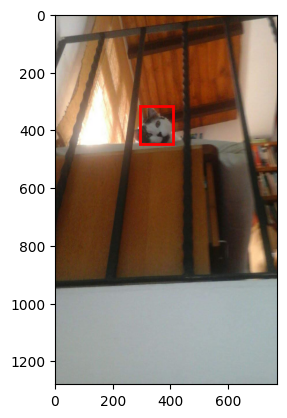

In [ ]:
see_cat_box(cat, bounding_box)


0: 640x640 1 cat, 410.2ms
1: 640x640 1 cat, 410.2ms
2: 640x640 1 cat, 410.2ms
3: 640x640 (no detections), 410.2ms
4: 640x640 (no detections), 410.2ms
5: 640x640 1 cat, 410.2ms
6: 640x640 1 cat, 410.2ms
7: 640x640 1 cat, 410.2ms
8: 640x640 1 cat, 410.2ms
9: 640x640 1 cat, 410.2ms
Speed: 10.1ms preprocess, 410.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


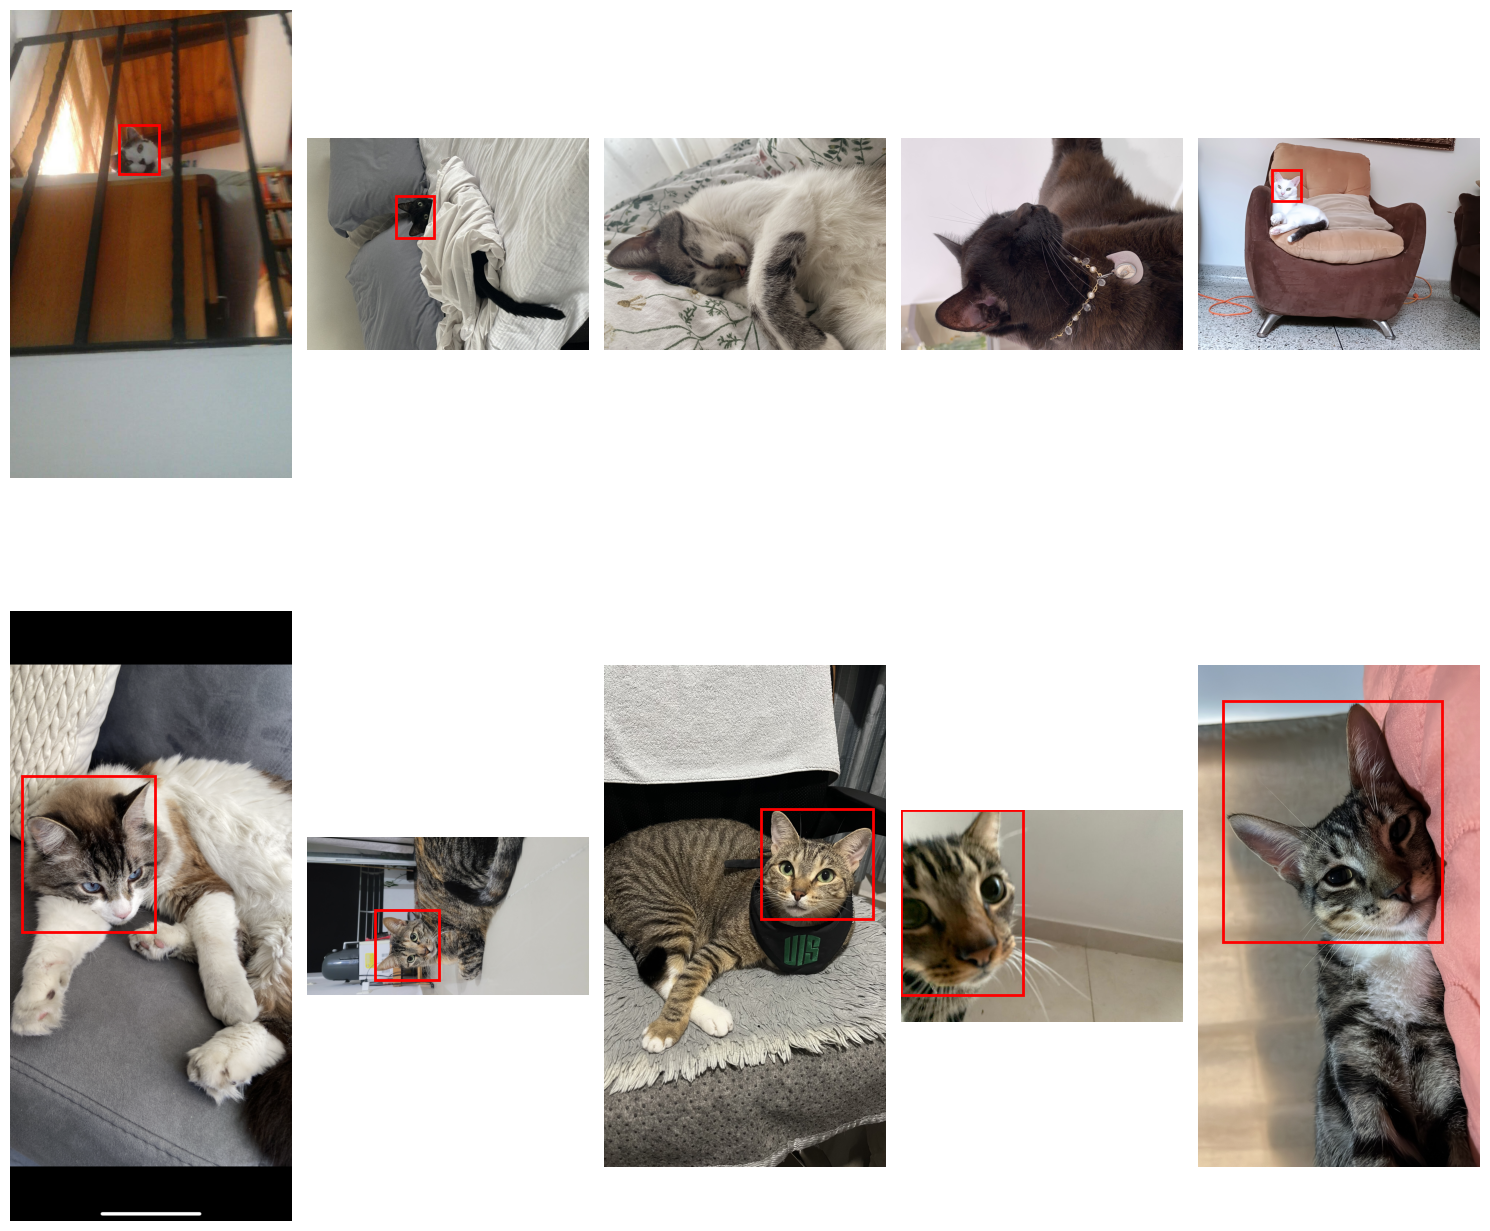

In [ ]:
cats = df.sample(n=10)
sources = cats.apply(lambda x: get_cat_path(x), axis=1).tolist()
results = yolo_face.predict(sources)

bounding_boxes = []
for r in results:
  xywhn = np.array(r.boxes.xywhn)
  if xywhn.shape[0] > 0:
    box = xywhn[0]
  else:
    box = np.array([0,0,0,0])
  bounding_boxes.append(box)

see_predictions(cats, bounding_boxes)

### Cuerpo del gatico
Con otro modelo diferente que sirve para ubicar todo el cuerpo del gatico

In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
import keras_cv
import tensorflow as tf

# Load the pretrained YOLOV8 backbone
yolo_cats = keras_cv.models.YOLOV8Detector.from_preset(preset ="yolo_v8_m_pascalvoc", bounding_box_format="xywh")

CAT_CLASS = 7 # la clase del gato en este dataset

Using TensorFlow backend


/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1/1 [==============================] - 10s 10s/step


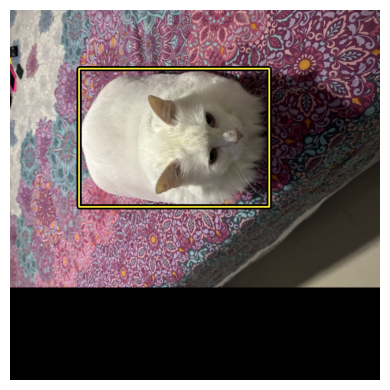

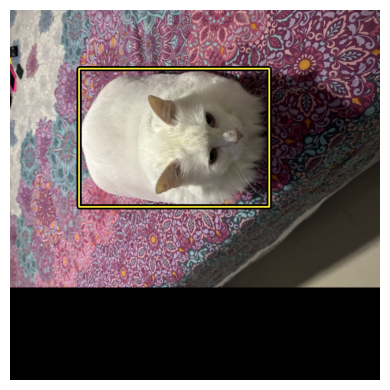

In [ ]:
cat = df.iloc[43]
cat_path = get_cat_path(cat)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

image_batch = inference_resizing([mpimg.imread(cat_path)])
y_pred = yolo_cats.predict(image_batch)

from keras_cv import visualization
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=4,
    font_scale=0.7,
    bounding_box_format="xywh"
)

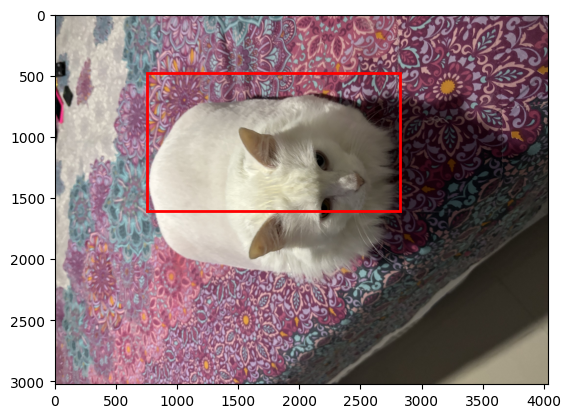

In [ ]:
#@title Intentando hacer el resize del bbox no sirvio pa naa :c
# Adjust bounding boxes back to original image size
cat_path = get_cat_path(df.iloc[43])
original_image = mpimg.imread(cat_path)

# Get original dimensions
original_height, original_width = original_image.shape[:2]

resized_width, resized_height = 640,640
scale_x = original_width / resized_width
scale_y = original_height / resized_height

box = y_pred["boxes"][0][0]
x, y, w, h = box[:]

w = w * scale_x
h = h * scale_y

x = x * scale_x
y = (y * scale_y)

new_bbox = np.array([x, y, w, h])

# para un bounding box normalizado
def bbox_nothing(img, bounding_box):
    return bounding_box[:]

# imprimir una caja para un gato
see_cat_box(cat, new_bbox, bbox_nothing)

### Cortar una imagen a partir de un bounding box

In [ ]:
def crop_bbox(image, bbox):
  image = image.astype(int)
  x,y,w,h = bbox[:].astype(int)

  cropped_image = image[y:y+h, x:x+w]
  return cropped_image

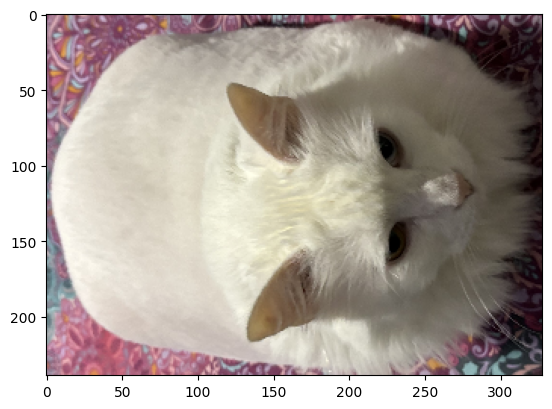

In [ ]:
if CAT_CLASS in y_pred["classes"]:
  # Obtener el index de la detección del gato
  pred_index = np.where(y_pred["classes"] == CAT_CLASS)[0][0]
  bbox = y_pred["boxes"][0][pred_index]

  resized_image = image_batch.numpy().astype(int)
  resized_image = resized_image.reshape(resized_image.shape[1:])

  cropped_image = crop_bbox(resized_image, bbox)

  # Save or display the cropped image
  #plt.imsave('cropped_image.jpg', cropped_image)
  plt.imshow(cropped_image)
  plt.show()

## Sacando los gatos de las imagenes: Juntandolo todo

In [ ]:
cats = df

In [ ]:
!pip install pillow

In [ ]:
import PIL
from PIL import Image, UnidentifiedImageError

# Verificar si los archivos existen y son válidos antes de predecir
for cat in cats.itertuples():
  source = get_cat_path(cat)
  try:
      Image.open(source)
  except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
       print(f"Error with file {source}: {e}")
       cats.drop(cat)  # Remove problematic files from the list

print("Numero de archivos a procesar:", cats.shape)

Numero de archivos a procesar: (968, 2)


In [ ]:
cats.iloc[0:2].iloc[0].id

'2-Boris'

In [ ]:
# Batch size para no quedarme sin ram
batch_size = 64
IMAGE_SIZE = 224

# obtener prediccion de la cara, recortar y guardar en una carpeta
def process_yolo_batch(cats_batch):
    try:
        sources = cats_batch.apply(lambda x: get_cat_path(x), axis = 1).tolist()
        results = yolo_face.predict(sources)
    except Exception as e:
        print(f"Error processing batch: {e}")
        return []

    cropped_faces = []
    for i in range(cats_batch.shape[0]):
      r = results[i]
      cat = cats_batch.iloc[i]
      xywhn = np.array(r.boxes.xywhn)
      original_img = r.orig_img[..., ::-1] # reversing colors order because its BGR

      if xywhn.shape[0] > 0:
        box = xywhn[0]
      else:
        # si la imagen no esta buena no la guardo
        continue

      box = np.array(bbox_normalized(original_img, box))
      cropped_face = crop_bbox(original_img, box)

      # guardar imagen en la carpeta de caras
      cropped_face_image = Image.fromarray(cropped_face.astype(np.uint8))
      cropped_face_image = cropped_face_image.resize((IMAGE_SIZE, IMAGE_SIZE))

      directory = '/content/drive/MyDrive/gatos_caras' + "/" + cat.id
      os.makedirs(directory, exist_ok = True)
      file_path = directory + "/" + cat.image
      cropped_faces.append(cropped_face_image)
      cropped_face_image.save(file_path)

    return cropped_faces

all_results = []
# Process the images in batches
for i in range(0, cats.shape[0], batch_size):
    batch = cats.iloc[i:i+batch_size]
    print("Processing batch ", i)
    batch_results = process_yolo_batch(batch)
    all_results.extend(batch_results)

# all_results now contains the results for all images
print("Finished processing all batches.")

Processing batch  0

0: 640x640 1 cat, 272.6ms
1: 640x640 1 cat, 272.6ms
2: 640x640 1 cat, 272.6ms
3: 640x640 1 cat, 272.6ms
4: 640x640 1 cat, 272.6ms
5: 640x640 1 cat, 272.6ms
6: 640x640 1 cat, 272.6ms
7: 640x640 1 cat, 272.6ms
8: 640x640 1 cat, 272.6ms
9: 640x640 1 cat, 272.6ms
10: 640x640 1 cat, 272.6ms
11: 640x640 1 cat, 272.6ms
12: 640x640 1 cat, 272.6ms
13: 640x640 1 cat, 272.6ms
14: 640x640 1 cat, 272.6ms
15: 640x640 1 cat, 272.6ms
16: 640x640 1 cat, 272.6ms
17: 640x640 1 cat, 272.6ms
18: 640x640 1 cat, 272.6ms
19: 640x640 1 cat, 272.6ms
20: 640x640 1 cat, 272.6ms
21: 640x640 1 cat, 272.6ms
22: 640x640 1 cat, 272.6ms
23: 640x640 1 cat, 272.6ms
24: 640x640 1 cat, 272.6ms
25: 640x640 1 cat, 272.6ms
26: 640x640 1 cat, 272.6ms
27: 640x640 (no detections), 272.6ms
28: 640x640 (no detections), 272.6ms
29: 640x640 1 cat, 272.6ms
30: 640x640 1 cat, 272.6ms
31: 640x640 1 cat, 272.6ms
32: 640x640 1 cat, 272.6ms
33: 640x640 1 cat, 272.6ms
34: 640x640 1 cat, 272.6ms
35: 640x640 1 cat, 272.6

In [ ]:
#@title Funcion para mostrar 10 imagenes de un np array
import random
def show_ten_cats(images):

  # Number of images to display
  num_images = 10
  random.shuffle(images)
  sampled_elements = random.sample(images, num_images)

  # Determine the grid size
  rows = 2
  cols = 5

  # Create a figure with subplots
  fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

  # Plot each image in the corresponding subplot
  for i in range(num_images):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes ticks

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

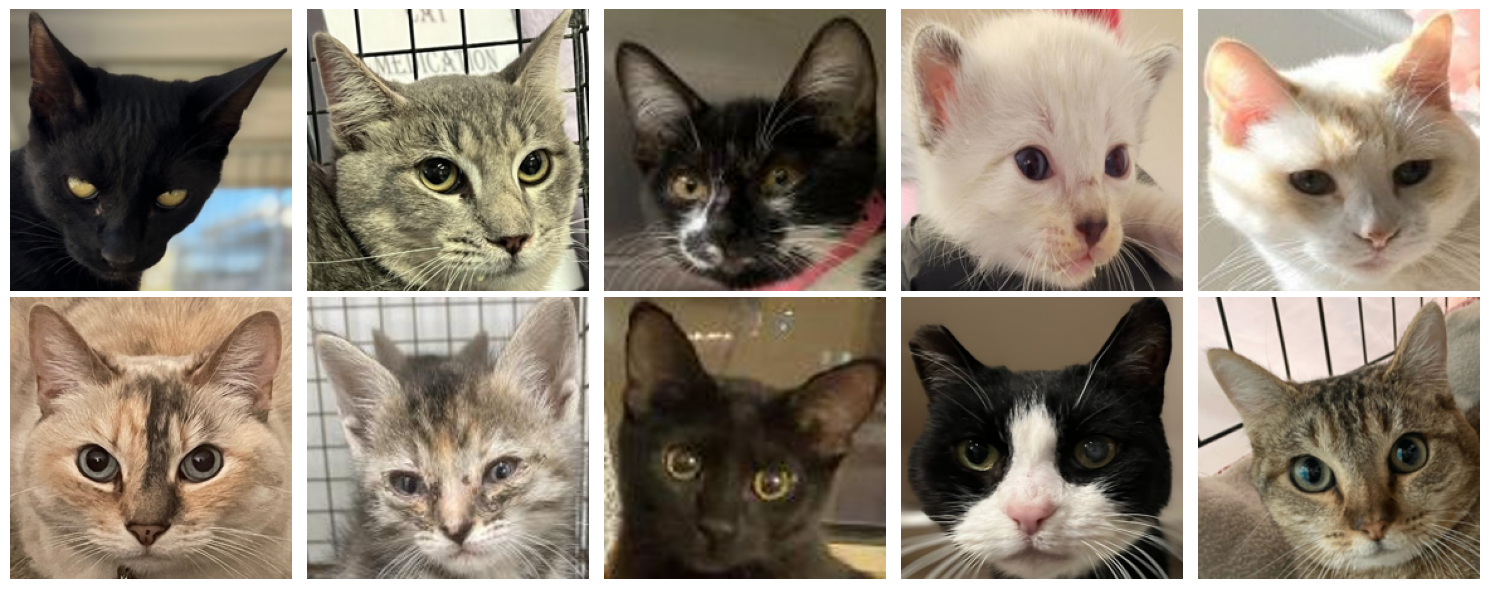

In [ ]:
show_ten_cats(all_results)

### hacer predicciones para Gato cuerpo completo
por ahora no tocare este tema

In [ ]:
# Predicciones de gato completo

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

def load_image_yolo_cats(cat):
  p = get_cat_path(cat)
  img = mpimg.imread(p)
  resized_image = inference_resizing([img])[0]
  return resized_image


# Define batch size
# toca por batches porque me quedo sin RAM
batch_size = 8

def process_batch(batch):
    # Load and resize images in the batch
    image_batch = batch.apply(lambda x: load_image_yolo_cats(x), axis=1).tolist()
    image_batch = np.array(image_batch)

    # Make predictions
    y_pred_batch = yolo_cats.predict(image_batch)
    return y_pred_batch, image_batch

# Split the dataset into batches
num_batches = len(cats) // batch_size + (1 if len(cats) % batch_size != 0 else 0)
all_predictions = []

resized_batches = []
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch = cats.iloc[start:end]

    y_pred_batch, image_batch = process_batch(batch)
    resized_batches.append(image_batch)
    all_predictions.append(y_pred_batch)

# Convert the list of predictions to a numpy array if needed
y_pred_yolo_cats = np.array(all_predictions)


NameError: name 'keras_cv' is not defined

In [ ]:
# faltten predictions contained in an array full of batches
# key is the string of the name of the key to get
def flatten_prediction_batches(prediction_array, key):
  object_values = [d[key] for d in prediction_array]
  values = []
  for i in object_values:
    values.extend(i)
  return values

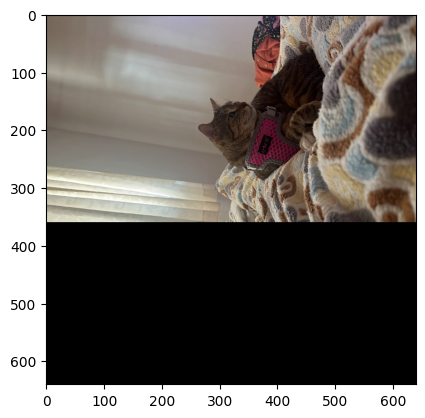

In [ ]:
plt.imshow(resized_images_all[13].astype(int))

In [ ]:
cropped_images_body = []
pred_boxes_all = flatten_prediction_batches(y_pred_yolo_cats, "boxes")
pred_classes_all = flatten_prediction_batches(y_pred_yolo_cats, "classes")
pred_confidence_all = flatten_prediction_batches(y_pred_yolo_cats, "confidence")
resized_images_all = []
for i in resized_batches:
    resized_images_all.extend(i)

for i in range(cats.shape[0]):
  pred_classes = pred_classes_all[i]
  pred_boxes = pred_boxes_all[i]
  pred_confidences = pred_confidence_all[i]
  cat = cats.iloc[i]

  if CAT_CLASS in pred_classes:
    # Obtener el index de la detección del gato
    pred_index = np.where(pred_classes == CAT_CLASS)[0][0]

    if (pred_confidences[pred_index] > 0.75):
      print(f"{cat.id} - {pred_confidences[pred_index]}")
      bbox = pred_boxes[pred_index]

      resized_image = resized_images_all[i].astype(int)
      cropped_image = crop_bbox(resized_image, bbox)
      cropped_images_body.append(cropped_image)

      # guardar imagen en la carpeta de cuerpos
      cropped_body_image = Image.fromarray(cropped_image.astype(np.uint8))
      directory = '/content/drive/MyDrive/gatos_organizado' + "/" + cat.id + "/body"
      #shutil.rmtree(directory, ignore_errors=True)
      os.makedirs(directory, exist_ok = True)
      file_path = directory + "/" + cat.image
      cropped_body_image.save(file_path)
      continue

  # si no esta muy seguro de lo que encontro o no encontro nada
  #p = get_cat_path(cats.iloc[i])
  #img = mpimg.imread(p)
  #cropped_images_body.append(img)

2-Boris - 0.9972356557846069
2-Boris - 0.9454643726348877
2-Boris - 0.948790431022644
4-Ramón (Moncho) - 0.8424592614173889
4-Ramón (Moncho) - 0.9698386788368225
5-Mochi - 0.9825690388679504
5-Mochi - 0.9737444519996643
5-Mochi - 0.9480569362640381
5-Mochi - 0.9791424870491028
6-Kyra - 0.9895416498184204
6-Kyra - 0.9888737797737122
6-Kyra - 0.9128785729408264
7-Hinata - 0.8495627641677856
7-Hinata - 0.9573180675506592
7-Hinata - 0.9813520908355713
8-Yuki - 0.9778723120689392
8-Yuki - 0.946942150592804
8-Yuki - 0.9913142919540405
10-Kiwi - 0.984986424446106
10-Kiwi - 0.9810066223144531
10-Kiwi - 0.9637193083763123
11-Oreo - 0.9440867900848389
11-Oreo - 0.8369142413139343
12-Akira  - 0.9749314785003662
12-Akira  - 0.9665223360061646
12-Akira  - 0.9743765592575073
13-Chimuelo - 0.9305477738380432
13-Chimuelo - 0.9854974746704102
14-Kira - 0.973366916179657
14-Kira - 0.9546417593955994
14-Kira - 0.9540199637413025
15-Lía - 0.9771080613136292
15-Lía - 0.988507866859436
17-Haku - 0.77514

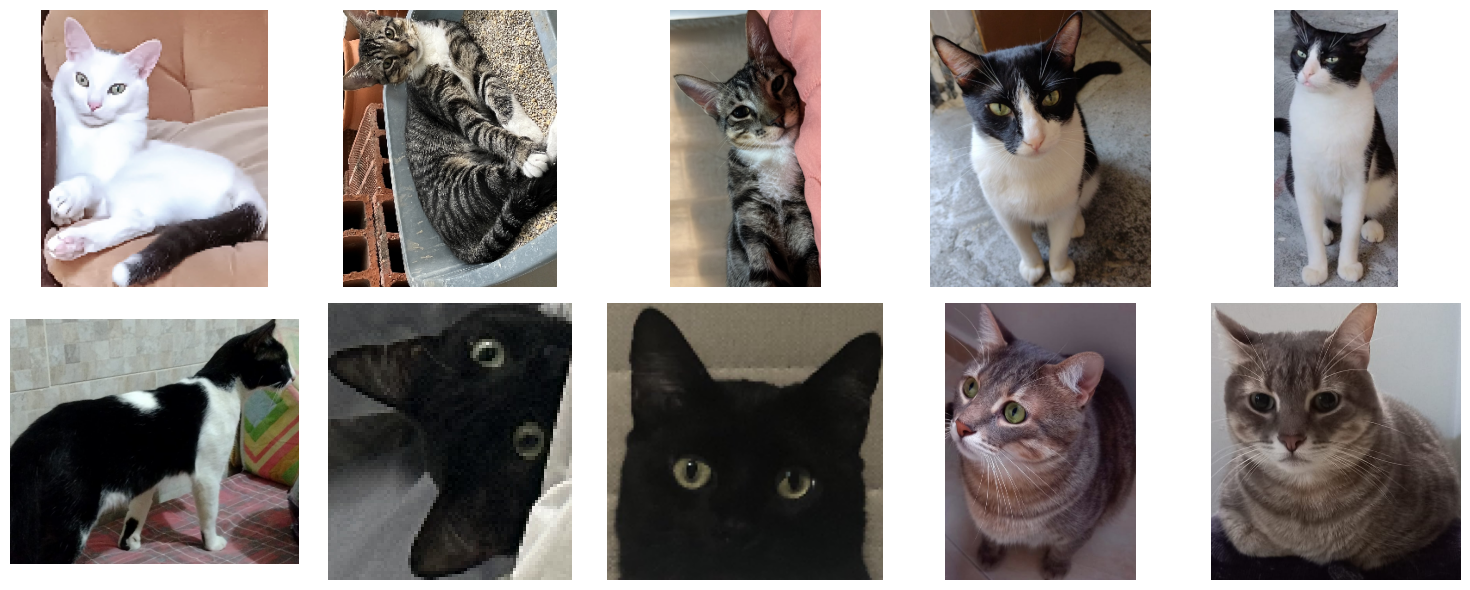

In [ ]:
show_ten_cats(cropped_images_body[20:30])

### Sacar imagenes a un zip file

In [ ]:
import zipfile
import os

# Specify the name of your uploaded file
zip_file_name = "/content/drive/MyDrive/gatos_caras (2).zip"

# Create a directory to extract to
extract_to = "/content/drive/MyDrive/gatos_caras_nuevo"
os.makedirs(extract_to, exist_ok=True)

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted files are in {extract_to}/")


Extracted files are in /content/drive/MyDrive/gatos_caras_nuevo/


##Guardar imagenes preprocesadas

In [ ]:
IMAGES_FOLDER = '/content/drive/MyDrive/gatos_caras_nuevo/gatos_caras/gatos_caras'

In [ ]:
folders = os.listdir(IMAGES_FOLDER)
image_data_face = []

for folder in folders:
  files = os.listdir(IMAGES_FOLDER + '/' + folder)
  for file in files:
    cat_name = folder
    file_name = IMAGES_FOLDER + "/" + folder + "/" + file
    image_data_face.append([cat_name, file_name])

# Create DataFrame
df_face = pd.DataFrame(image_data_face, columns=['id', 'image'])

In [ ]:
# Con las caras de los gatos filtradas, debo asegurarme de tener por lo menos dos fotos de un mismo gato
gato_solo = df_face.groupby('id').filter(lambda x: len(x) < 2)
gato_solo.head()

df_face = df_face.groupby('id').filter(lambda x: len(x) >= 2)

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os

# Load the dataset
df =  df_face

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    return img_array

image_arrays = []
ids = []

for _, row in df.iterrows():
    image_path = row['image']
    cat_id = row['id']

    # Convert the image to an array
    img_array = load_and_preprocess_image(image_path)

    # Store the array and ID
    image_arrays.append(img_array)
    ids.append(cat_id)

# Convert lists to numpy arrays
image_arrays = np.array(image_arrays)
ids = np.array(ids)

# Save the arrays to .npy files
np.save('images_nuevo.npy', image_arrays)
np.save('ids_nuevo.npy', ids)

print("Images and IDs have been saved to .npy files.")


Images and IDs have been saved to .npy files.


In [ ]:
data1.shape

(855,)

In [ ]:
# juntar con las imagenes que ya tenia
data1 = np.load('/content/ids_gatos.npy')
data2 = np.load('/content/images_gatos.npy')

print(data1.shape)
print(data2.shape)

#combined_data = np.concatenate((data1, data2), axis=0)


(4730,)
(4730, 224, 224, 3)


# Obtener imagenes ya preprocesadas!
Las imagenes ya recortadas estan guardadas en unas carpetas, aqui las obtengo para meterlas a la red de identificacion de gatos

In [4]:
def get_cat(cat):
  image = np.frombuffer(cat.image, dtype=np.uint8)
  return image.reshape((224,224,3))

def show_cat(cat):
  img = get_cat(cat)
  plt.imshow(img)
  plt.show()

In [6]:
# Load the image arrays and IDs
image_arrays = np.load('/content/drive/MyDrive/proyecto_ia_gaticos/images_gatos.npy')
ids = np.load('/content/drive/MyDrive/proyecto_ia_gaticos/ids_gatos.npy')

# Convert image arrays to byte arrays for storage in DataFrame
image_arrays_bytes = [img_array.tobytes() for img_array in image_arrays]

# Create the DataFrame
df_face = pd.DataFrame({
    'id': ids,
    'image': image_arrays_bytes
})

Limpiar el dataframe y obetener datos de training, testeo y validacion

In [ ]:
id_counts = df_face.groupby('id').size()

# Find min and max counts
min_count = id_counts.min()
max_count = id_counts.max()

print(f"Minimum count: {min_count}")
print(f"Maximum count: {max_count}")

Minimum count: 2
Maximum count: 6


In [ ]:
df_face["id"].unique().shape

(1416,)

In [ ]:
df_face.shape

(4730, 2)

In [7]:
from sklearn.model_selection import train_test_split
# Function to split the dataset
def split_dataset(df, test_size, random_state=123):
    unique_ids = df['id'].unique()

    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state, shuffle=True)

    train_df = df[df['id'].isin(train_ids)]
    test_df = df[df['id'].isin(test_ids)]

    return train_df, test_df

train_df, val_df = split_dataset(df_face, 0.4)

train_unique_ids = train_df["id"].unique()
val_unique_ids = val_df["id"].unique()

print(f"Cantidad de gatos para entrenamiento {train_unique_ids.shape[0]}):")
print("Imagenes de entrenamiento: ", train_df.shape)

print(f"\nCantidad de gatos para validacion y testeo {val_unique_ids.shape[0]}):")
print("Imagenes de testeo y validacion", val_df.shape)

Cantidad de gatos para entrenamiento 849):
Imagenes de entrenamiento:  (2816, 2)

Cantidad de gatos para validacion y testeo 567):
Imagenes de testeo y validacion (1914, 2)


In [8]:
np.save("train.npy", train_df)
np.save("val.npy", val_df)

## Modelos preentrenados

### Modelo efficientNet

In [ ]:
#@title Arquitectura EfficentNet
from IPython.display import display, HTML
# Example URL of an image
image_url = 'https://skyengine.ai/se/images/blog/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks.png'
# Display the image with specific size
display(HTML(f'<img src="{image_url}" width="800" height="300">'))

In [9]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2, preprocess_input as efficientNetPreprocessInput

# Load the EfficientNetB2 model with pre-trained ImageNet weights (excluding top layers)
efficientNet_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224,224,3))


31790344/31790344 [==============================] - 0s 0us/step


In [ ]:
len(efficientNet_model.layers)

340

In [ ]:
efficientNet_model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1

# Modelo siames

In [10]:
MODEL_IMAGE_SIZE = 224

In [11]:
def get_embedding_module(imageSize, baseCnn, base_Cnn_preprocesor, embedding_size):
    # construct the input layer and pass the inputs through a
    # pre-processing layer
    inputs = keras.Input(imageSize + (3,))
    x = base_Cnn_preprocesor(inputs)

    # pass the pre-processed inputs through the base cnn and get the
    # extracted features from the inputs
    extractedFeatures = baseCnn(x)
    # pass the extracted features through a number of trainable layers
    x = keras.layers.GlobalAveragePooling2D()(extractedFeatures)
    outputs = keras.layers.Dense(units=embedding_size, activation = "relu")(x)
    # build the embedding model and return it
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

In [12]:
def get_siamese_network(imageSize, embeddingModel):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=imageSize + (3,))
    positiveInput = keras.Input(name="positive", shape=imageSize + (3,))
    negativeInput = keras.Input(name="negative", shape=imageSize + (3,))

    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding]
    )
    return siamese_network

In [13]:
# modelo con la red siamesa
class SiameseModel(keras.Model):
    def __init__(self, network, margin,d, alpha, lossTracker, accuracyTracker, accuracyTracker2):
        super().__init__()
        self.network = network
        self.margin = margin
        self.d = d
        self.alpha = alpha
        self.lossTracker = lossTracker
        self.accuracyTracker = accuracyTracker
        self.accuracyTracker2 = accuracyTracker2


    def _compute_distance(self, anchorEmbedding, positiveEmbedding, negativeEmbedding):
        # calculate the anchor to positive and negative distance
        apDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - positiveEmbedding), axis=-1
        )
        anDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - negativeEmbedding), axis=-1
        )

        # return the distances
        return (apDistance, anDistance)

    def get_embeddings(self, inputs):
        (anchor, positive, negative) = inputs
        # embed the images
        embeddings = self.network((anchor, positive, negative))
        anchorEmbedding = embeddings[0]
        positiveEmbedding = embeddings[1]
        negativeEmbedding = embeddings[2]
        return (anchorEmbedding, positiveEmbedding, negativeEmbedding)

    def _compute_loss(self, anchorEmbedding, positiveEmbedding, negativeEmbedding):
      apDistance = tf.reduce_sum(tf.square(anchorEmbedding - positiveEmbedding), axis=-1)
      anDistance = tf.reduce_sum(tf.square(anchorEmbedding - negativeEmbedding), axis=-1)
      l_triplet = apDistance - anDistance
      loss = tf.maximum(l_triplet + self.margin , 0.0)
      return loss

    def _compute_accuracy(self, apDistance, anDistance):
      # cantidad de predicciones donde positivo < margin y negativo > margin
      correct_predictions = tf.reduce_sum(tf.cast((apDistance < self.margin) & (anDistance > self.margin), tf.float32))
      # proporcion de predicciones correctas buenas_distancias / cantidad de distancias calculadas
      accuracy = correct_predictions / tf.cast(tf.shape(apDistance)[0], tf.float32)
      return accuracy

    def _compute_accuracy2(self, apDistance, anDistance):
      # cantidad de predicciones donde positivo < margin y negativo > margin
      correct_predictions = tf.reduce_sum(tf.cast((apDistance < anDistance), tf.float32))
      # proporcion de predicciones correctas buenas_distancias / cantidad de distancias calculadas
      accuracy = correct_predictions / tf.cast(tf.shape(apDistance)[0], tf.float32)
      return accuracy


    def call(self, inputs):
        # Compute the distance between the anchor and positive, negative images
        anchorEmbedding, positiveEmbedding, negativeEmbedding = self.get_embeddings(inputs)
        apDistance, anDistance = self._compute_distance(anchorEmbedding, positiveEmbedding, negativeEmbedding)
        return apDistance, anDistance

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            anchorEmbedding, positiveEmbedding, negativeEmbedding = self.get_embeddings(inputs)
            apDistance, anDistance = self._compute_distance(anchorEmbedding, positiveEmbedding, negativeEmbedding)
            loss = self._compute_loss(anchorEmbedding, positiveEmbedding, negativeEmbedding)

        gradients = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))

        self.lossTracker.update_state(loss)
        accuracy = self._compute_accuracy(apDistance, anDistance)
        self.accuracyTracker.update_state(accuracy)
        accuracy2 = self._compute_accuracy2(apDistance, anDistance)
        self.accuracyTracker2.update_state(accuracy2)

        return {"loss": self.lossTracker.result(),
                "accuracy": self.accuracyTracker.result(),
                "accuracy2": self.accuracyTracker2.result()}

    def test_step(self, inputs):
        anchorEmbedding, positiveEmbedding, negativeEmbedding = self.get_embeddings(inputs)
        apDistance, anDistance = self._compute_distance(anchorEmbedding, positiveEmbedding, negativeEmbedding)
        loss = self._compute_loss(anchorEmbedding, positiveEmbedding, negativeEmbedding)

        self.lossTracker.update_state(loss)
        accuracy = self._compute_accuracy(apDistance, anDistance)
        self.accuracyTracker.update_state(accuracy)
        accuracy2 = self._compute_accuracy2(apDistance, anDistance)
        self.accuracyTracker2.update_state(accuracy2)

        return {"loss": self.lossTracker.result(),
                "accuracy": self.accuracyTracker.result(),
                "accuracy2": self.accuracyTracker2.result()}


    def save_weights(self, filepath, overwrite=True, save_format=None):
        self.network.save_weights(filepath)

    def save_model(self, filepath, overwrite=True,  include_optimizer=True, save_format=None):
        self.network.save(filepath)

    def load_weights(self, filepath):
        self.network.load_weights(filepath)

    def get_model(self):
      return self.network

    @property
    def metrics(self):
        return [self.lossTracker]

In [14]:
MODEL_IMAGE_SIZE = 224
IMAGE_SIZE = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)

margin = 0.4 # distancia de separacion de los vectores
d = 64 # embedding size
alpha = 1.1 # hiperparametro de gor

embeddingModel = get_embedding_module(IMAGE_SIZE, efficientNet_model, efficientNetPreprocessInput, d)
embeddingModel.compile(optimizer=keras.optimizers.Adam(0.001))

siamese_network = get_siamese_network(IMAGE_SIZE, embeddingModel)

siameseModel = SiameseModel(
	network = siamese_network,
	margin=margin,
	d=d,
	alpha=alpha,
	lossTracker=keras.metrics.Mean(name="loss"),
	accuracyTracker = keras.metrics.Mean(name="accuracy"),
	accuracyTracker2 = keras.metrics.Mean(name="accuracy"),
)

In [15]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# compile the siamese model
LEARNING_RATE = 0.0001

siameseModel.compile(
	optimizer=keras.optimizers.Adam(LEARNING_RATE),
	weighted_metrics=[] # silence warning
)

# Guardar hardest negative samples

In [16]:
import random
def process_cat(image):
  #image = mpimg.imread(cat.image)
  image = np.frombuffer(image, dtype=np.uint8)
  # Reshape the array to the original image shape
  image = image.reshape((224,224,3))

  # Check if the image is already normalized
  if image.min() < 0 or image.max() > 1:
      # normalizing image
      image = image / 255.
  return image

In [18]:
siameseModel.load_weights("/content/drive/MyDrive/proyecto_ia_gaticos/modelo_siames_best1.h5")
siameseModel.compile(
	optimizer=keras.optimizers.Adam(0.0001),
	weighted_metrics=[] # silence warning
)

In [19]:
# Codigo para obtener los embeddings de todas las imagenes
i = 0
images_numpy = []
embeddings = []

while i < train_df.shape[0]:
  if i >= train_df.shape[0] - 2:
    break
  cat1 = train_df.iloc[i]
  cat2 = train_df.iloc[i+1]
  cat3 = train_df.iloc[i+2]

  image1 = process_cat(cat1["image"])
  image2 = process_cat(cat2["image"])
  image3 = process_cat(cat3["image"])

  images_numpy.append(image1)
  images_numpy.append(image2)
  images_numpy.append(image3)

  image1 = image1.reshape(1,224,224,3)
  image2 = image2.reshape(1,224,224,3)
  image3 = image3.reshape(1,224,224,3)

  image1 = tf.convert_to_tensor(image1, dtype=tf.float32)
  image2 = tf.convert_to_tensor(image2, dtype=tf.float32)
  image3 = tf.convert_to_tensor(image3, dtype=tf.float32)

  embedding1, embedding2, embedding3 = siameseModel.get_embeddings((image1 , image2, image3))
  embedding1 = embedding1.numpy()
  embedding2 = embedding2.numpy()
  embedding3 = embedding3.numpy()

  embeddings.append(embedding1)
  embeddings.append(embedding2)
  embeddings.append(embedding3)

  i = i + 3


# y ahora los que faltaron
while i < train_df.shape[0]:
  cat = train_df.iloc[i]
  image = process_cat(cat["image"])
  images_numpy.append(image)
  image = image.reshape(1,224,224,3)
  image = tf.convert_to_tensor(image, dtype=tf.float32)
  embedding, _ ,_  = siameseModel.get_embeddings((image, image, image))
  embedding = embedding.numpy()
  embeddings.append(embedding)
  i = i + 1

In [20]:
np.save("/content/drive/MyDrive/proyecto_ia_gaticos/embeddings_train.npy", embeddings)

In [ ]:
embeddings = np.load("/content/drive/MyDrive/embeddings_all2.npy")

In [23]:
embeddings = np.array(embeddings)
embeddings = embeddings.reshape(embeddings.shape[0], -1)
print(embeddings.shape)

(2816, 64)


In [28]:
labels = train_df["id"].values
print(labels.shape)

(2816,)


In [34]:
labels

array(['2-Boris', '2-Boris', '2-Boris', ..., '99959', '99959', '99959'],
      dtype=object)

In [29]:
# Compute distances to each embedding
rank = 30  # How many hardest distances
results = []
sorted_d = []
idx = 0
for _, row in train_df.iterrows():
    cat_embedding = embeddings[idx]
    distances = []

    # Create negative_embeddings array

    negative_embeddings_indexes = [i for i, embedding in enumerate(embeddings) if labels[i] != labels[idx]]

    for i in negative_embeddings_indexes:
        d = np.sum(np.square(cat_embedding - embeddings[i]))
        if d < 0.1
        distances.append((d, i))

    # Sort distances by descending order (hardest negatives first)
    distances.sort(reverse=False, key=lambda x: x[0])
    hardest_negatives = [index for _, index in distances[:rank]]
    s = [d for d, _ in distances[:rank]]
    results.append(hardest_negatives)
    sorted_d.append(s)
    idx = idx + 1

# 'results' now contains lists of 10 hardest negative indexes for each image in the dataset



In [43]:
np.save("/content/drive/MyDrive/proyecto_ia_gaticos/hardest_negatives30.npy", results)
np.save("/content/drive/MyDrive/proyecto_ia_gaticos/distancias_negativos30.npy", sorted_d)

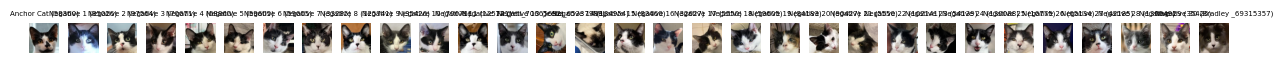

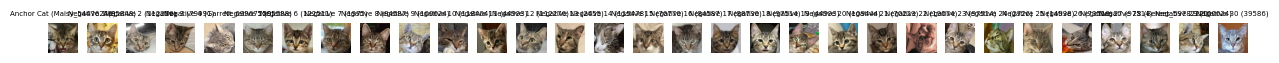

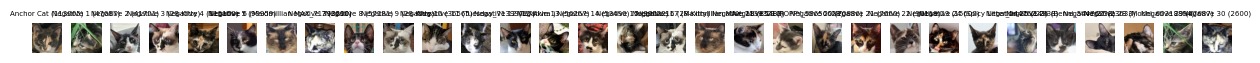

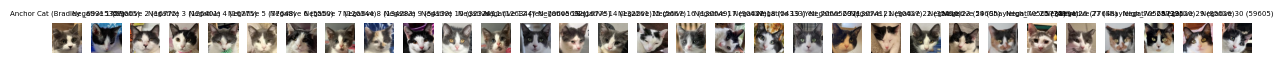

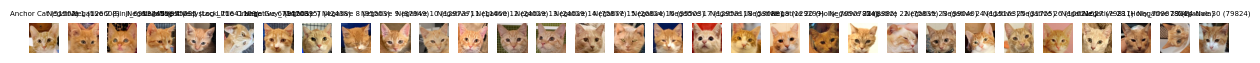

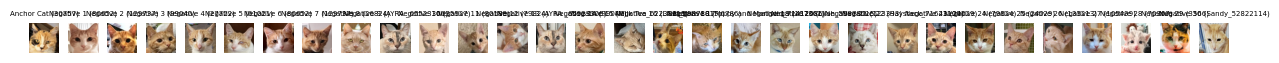

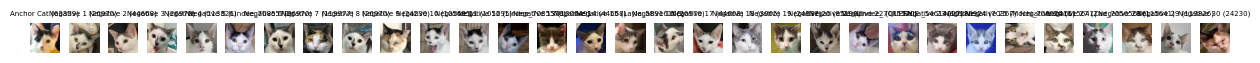

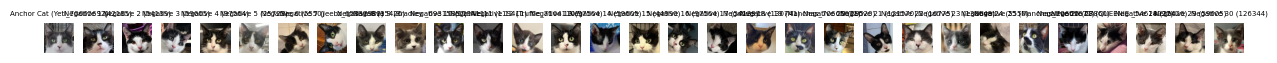

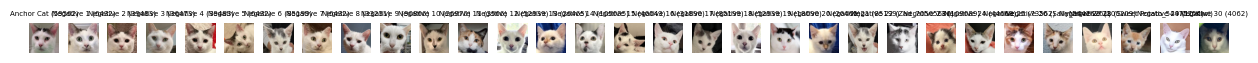

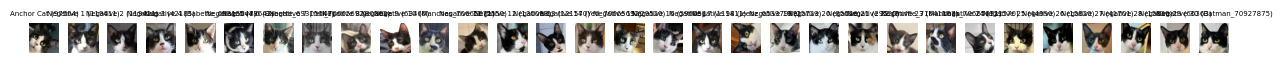

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'results' populated with lists of indexes
# results = [[neg_indices_for_cat_1], [neg_indices_for_cat_2], ...]

# Define a function to plot images
def plot_cats_with_negatives(anchor_idx, negatives_indices, embeddings, labels, n_negatives=10):
    plt.figure(figsize=(15, 8))
    plt.subplot(2, n_negatives + 1, 1)
    plt.title(f"Anchor Cat ({labels[anchor_idx]})",fontsize=5)
    plt.imshow(process_cat(train_df.iloc[anchor_idx]['image']))
    plt.axis('off')

    for i, neg_idx in enumerate(negatives_indices):
        plt.subplot(2, n_negatives + 1, i + 2)
        plt.title(f"Negative {i+1} ({labels[neg_idx]})", fontsize=5)
        plt.imshow(process_cat(train_df.iloc[neg_idx]['image']))
        plt.axis('off')

    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
    plt.show()

# Randomly select 10 anchor cats and plot their corresponding hardest negatives
num_samples = 10
sample_indices = np.random.choice(len(results), num_samples, replace=False)

for idx in sample_indices:
    anchor_idx = idx
    negatives_indices = results[idx]
    plot_cats_with_negatives(anchor_idx, negatives_indices, embeddings, labels, n_negatives=30)
